In [1]:
print('hi')

hi


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_278/912317896.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tokens = pd.read_sql("SELECT DISTINCT token FROM sma_signals", conn)['token'].tolist()
/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_278/912317896.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"""
/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_278/912317896.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  signals = pd.read_sql(f"""
/var/folders/5s

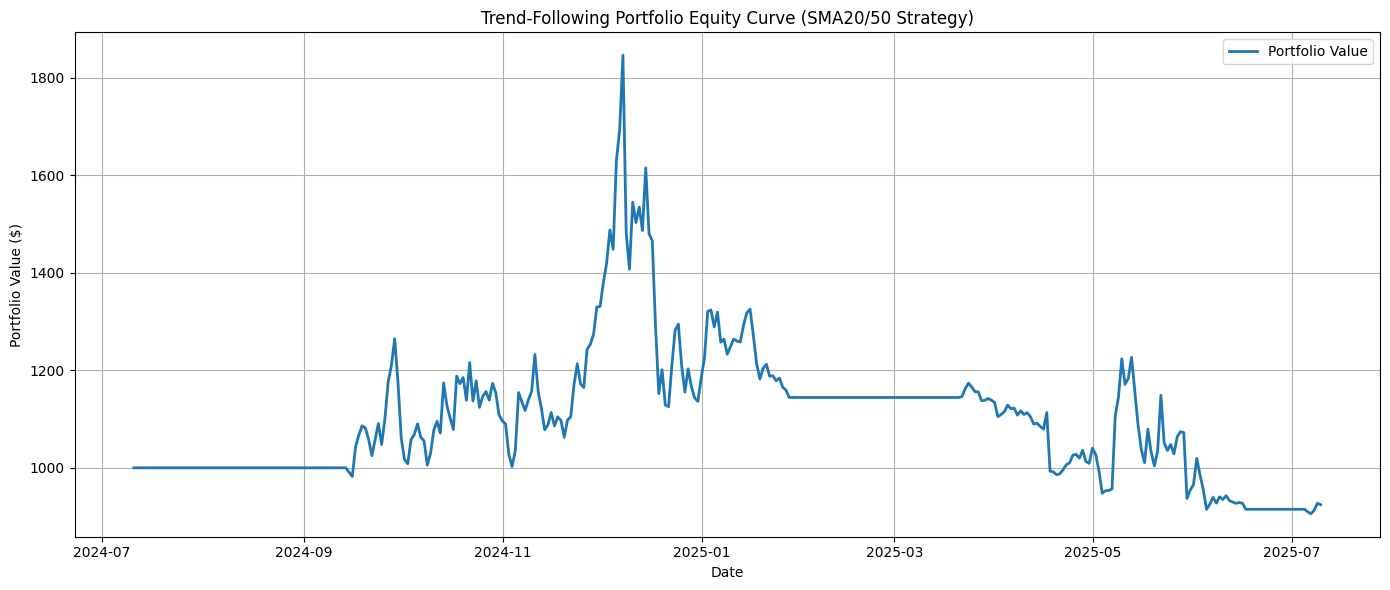

📈 Final Token Values:
MERL_USDT: $111.62
BIGTIME_USDT: $141.31
AIDOGE_USDT: $59.04
VELO_USDT: $222.42
SUSHI_USDT: $390.03

💰 Final Portfolio Value: $924.41


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from datetime import timedelta

# DB connection
conn = psycopg2.connect(
    dbname="crypto_index",
    user="postgres",
    password="postgres",  # Update if needed
    host="localhost",
    port=5432
)

# Get tokens from sma_signals
tokens = pd.read_sql("SELECT DISTINCT token FROM sma_signals", conn)['token'].tolist()

# Capital settings
initial_capital = 1000
capital_per_token = initial_capital / len(tokens)

# Store final value per token
token_results = {}

# For plotting
portfolio_curve = pd.DataFrame()

for token in tokens:
    # Load price data
    df = pd.read_sql(f"""
        SELECT timestamp, close
        FROM ohlcv_data
        WHERE token = '{token}'
        ORDER BY timestamp
    """, conn)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Load signals
    signals = pd.read_sql(f"""
        SELECT timestamp, signal
        FROM sma_signals
        WHERE token = '{token}'
        ORDER BY timestamp
    """, conn)
    signals['timestamp'] = pd.to_datetime(signals['timestamp'])

    # Track position & equity
    in_position = False
    entry_price = 0
    cash = capital_per_token
    token_holding = 0
    equity_curve = []

    for current_time in df.index:
        price = df.loc[current_time, 'close']

        # If there’s a signal today, update position
        signal_today = signals[signals['timestamp'] == current_time]
        if not signal_today.empty:
            signal = signal_today['signal'].values[0]

            if signal == 'bullish_crossover' and not in_position:
                # Buy
                token_holding = cash / price
                entry_price = price
                cash = 0
                in_position = True

            elif signal == 'bearish_crossover' and in_position:
                # Sell
                cash = token_holding * price
                token_holding = 0
                in_position = False

        # Mark-to-market portfolio value
        value = token_holding * price + cash
        equity_curve.append((current_time, value))

    # Final value
    final_value = equity_curve[-1][1]
    token_results[token] = final_value

    # Store equity curve for plotting
    token_df = pd.DataFrame(equity_curve, columns=['timestamp', token])
    token_df.set_index('timestamp', inplace=True)

    if portfolio_curve.empty:
        portfolio_curve = token_df
    else:
        portfolio_curve = portfolio_curve.join(token_df, how='outer')

# Fill forward missing values
portfolio_curve.fillna(method='ffill', inplace=True)

# Compute total portfolio value over time
portfolio_curve['Total'] = portfolio_curve.sum(axis=1)

# Plot equity curve
plt.figure(figsize=(14, 6))
plt.plot(portfolio_curve.index, portfolio_curve['Total'], label='Portfolio Value', linewidth=2)
plt.title("Trend-Following Portfolio Equity Curve (SMA20/50 Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Show final results
print("📈 Final Token Values:")
for token, value in token_results.items():
    print(f"{token}: ${value:.2f}")

print(f"\n💰 Final Portfolio Value: ${sum(token_results.values()):.2f}")
